Models aren't very good here. Relied on one movie with lots of crops from that movie. Relied on large amounts of max pooling. Achieving exact pixel values isn't as important. I want to retain CCS location information and general membrane structure. Future attempts fully trump everything here.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.io import *
from fastai.conv_learner import *
from fastai.column_image_data import *
from PIL import Image
from matplotlib import animation, rc
from IPython.display import HTML
from skimage.measure import block_reduce
import time
from IPython.display import clear_output

In [116]:
PATH='D:\\Code\\kural_work\\movie_generation\\data\\'
img_ = Image.open(PATH+'s01_5m_2s_100ms_25p.tif')
nf = img_.n_frames #number of frames

img = []

width = 128
num_angles = 1
center = [230, 245]
rad = 130
edge_param = 0.5 #0.7
r = rad-edge_param*128//2
crop_cent = []
for i in range(num_angles):
    crop_cent.append((np.int(center[0]+r*np.sin(2*np.pi*i/num_angles)), np.int(center[1]+r*np.cos(2*np.pi*i/num_angles))))
for t, l in crop_cent:
    base_img = []
    for i in range(nf):
        img_.seek(i)
        img.append(np.asarray(list(img_.getdata())).reshape(512,512)[t-width//2:t+width//2,l-width//2:l+width//2])
        base_img.append(img[-1])
    for t in range(2):
        for k in range(0,4):
            if t==0 and k==0: continue
            for i in range(len(base_img)):
                if t==0:
                    img.append(np.rot90(base_img[i],k=k))
                else:
                    img.append(np.rot90(base_img[i].T,k=k))

img = np.stack(img)
img = torch.from_numpy(np.ascontiguousarray(img)).float()
img = (img-img.min().item())/(img.max().item()-img.min().item())
img = img.view(nf*num_angles*8,1,width,width)
kernel_size = 8
img_pool = nn.MaxPool2d(kernel_size)(img)
img_pool = img_pool.view(nf*num_angles*8,width**2//kernel_size**2)
img_pool = img_pool.cuda()
img_crop = []
for t in range(0,128,64):
    for l in range(0,128,64):
        for i in range(nf):
            img_crop.append(img[t:t+64,l:l+64])

In [119]:
test_range = slice(100,104)
pooled_clip = img_pool[test_range]
img_crop = []
for t in range(0,128,64):
    for l in range(0,128,64):
        img_crop.append(img[test_range,:,t:t+64,l:l+64])
img_crop = torch.cat(img_crop).cuda()

In [77]:
img_crop.shape

torch.Size([16, 1, 64, 64])

In [26]:
class NFrameModel(nn.Module):
    def __init__(self, num_input_frames=3):
        super().__init__()
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fch1 = nn.Linear(num_input_frames*32, num_input_frames*32)
        self.fch2 = nn.Linear(num_input_frames*32, 32)
        self.fc3r = nn.Linear(32, 64)
        self.fc2r = nn.Linear(64, 128)
        self.fc1r = nn.Linear(128, 256)
        self.nf = num_input_frames
        
    def forward(self, img):
        codings = []
        for i in range(self.nf):
            if len(img.shape)==2:
                codings.append(F.relu(self.fc1(img[i].view(1,-1))))
            elif len(img.shape)==3:
                codings.append(F.relu(self.fc1(img[:,i,:])))
            codings[i] = F.relu(self.fc2(codings[i]))
            codings[i] = F.relu(self.fc3(codings[i]))
        h = torch.tanh(self.fch1(torch.cat(list(codings),dim=1).view(-1,self.nf*32)))
        h = torch.tanh(self.fch2(h))
        h = F.relu(self.fc3r(h))
        h = F.relu(self.fc2r(h))
        h = torch.clamp(self.fc1r(h),0,1)
        
        return h

In [121]:
rnn_model = NFrameModel().cuda()
rnn_model.load_state_dict(torch.load(r'C:\Users\joshu\Documents\fastai\courses\kural_work\rnn_model.pth'))

In [58]:
class ActualMaxPoolDecoderModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(8**2,16**2)
        self.fc2 = nn.Linear(16**2,32**2)
        self.fc3 = nn.Linear(32**2,64**2)
        
    def forward(self, x):
        x = x.contiguous().view(-1,8**2)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.clamp(self.fc3(x),0,1)
        return x

In [59]:
decoder_model = ActualMaxPoolDecoderModel().cuda()
sd_path = 'C:\\Users\\joshu\\Documents\\fastai\\courses\\kural_work\\MaxPoolDecoderModel.pth'
for key, value in torch.load(sd_path).items():
    layer, worb = key.split('.')
    if layer in dir(decoder_model):
        setattr(getattr(getattr(decoder_model,layer),worb),'data',value)

In [83]:
class MaxPoolDecoderModel(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.mp = nn.MaxPool2d(kernel_size)
        self.fc1 = nn.Linear(8**2,16**2)
        self.fc2 = nn.Linear(16**2,32**2)
        self.fc3 = nn.Linear(32**2,64**2)
        
    def forward(self, x):
        x = self.mp(x).view(-1,8**2)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.clamp(self.fc3(x),0,1)
        return x
test_decoder_model = MaxPoolDecoderModel(8).cuda()
test_decoder_model.load_state_dict(torch.load('C:\\Users\\joshu\\Documents\\fastai\\courses\\kural_work\\MaxPoolDecoderModel.pth'))

In [117]:
out = rnn_model(pooled_clip)

In [86]:
pooled_clip.shape

torch.Size([4, 256])

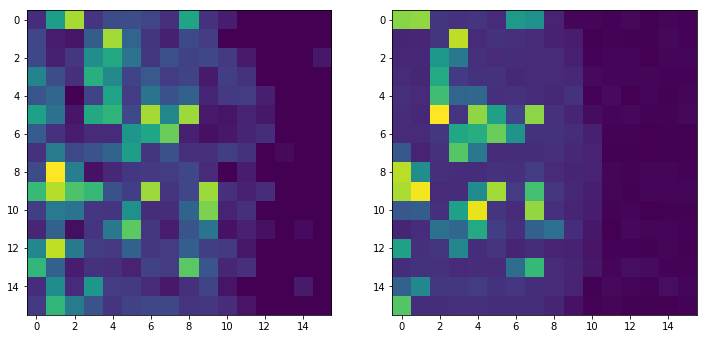

In [120]:
fig, ax = plt.subplots(1,2, figsize = [12,6])
ax[0].imshow(out.data.view(16,16).cpu().numpy())
ax[1].imshow(pooled_clip[3,:].view(16,16).data.cpu())

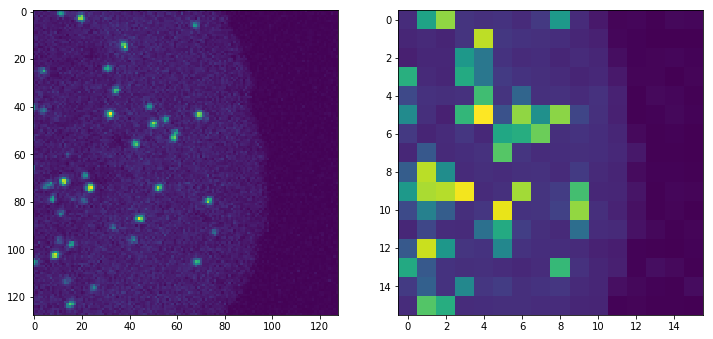

In [90]:
img_uncrop = torch.cat([torch.cat([img_crop[3,0,:,:], img_crop[7,0,:,:]],dim=1),
                        torch.cat([img_crop[11,0,:,:], img_crop[15,0,:,:]],dim=1)],
                       dim=0)
fig, ax = plt.subplots(1,2,figsize=[12,6])
ax[0].imshow(img_uncrop.data.cpu())
ax[1].imshow(nn.MaxPool2d(8)(img_uncrop[None,:,:]).view(16,16).data.cpu())

In [72]:
tmp = []
for t in range(0,16,8):
    for l in range(0,16,8):
        tmp.append(out.view(16,16)[t:t+8,l:l+8])
tmp_expand = torch.cat([decoder_model(t).view(1,64,64) for t in tmp])


In [73]:
tmp_expand.shape

torch.Size([4, 64, 64])

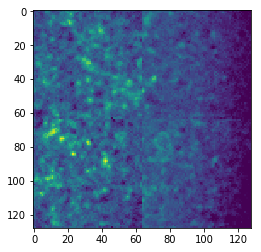

In [74]:
tmp_expand = torch.cat([torch.cat([tmp_expand[0,:,:], tmp_expand[1,:,:]],dim=1),
                        torch.cat([tmp_expand[2,:,:], tmp_expand[3,:,:]],dim=1)],
                       dim=0)
plt.imshow(tmp_expand.data.cpu())

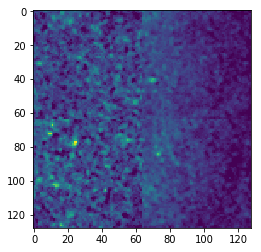

In [84]:
tmp_expand = torch.cat([torch.cat([test_decoder_model(img_crop[3,:,:,:]).view(64,64), test_decoder_model(img_crop[7,:,:,:]).view(64,64)],dim=1),
                        torch.cat([test_decoder_model(img_crop[11,:,:,:]).view(64,64), test_decoder_model(img_crop[15,:,:,:]).view(64,64)],dim=1)],
                       dim=0)
plt.imshow(tmp_expand.data.cpu())

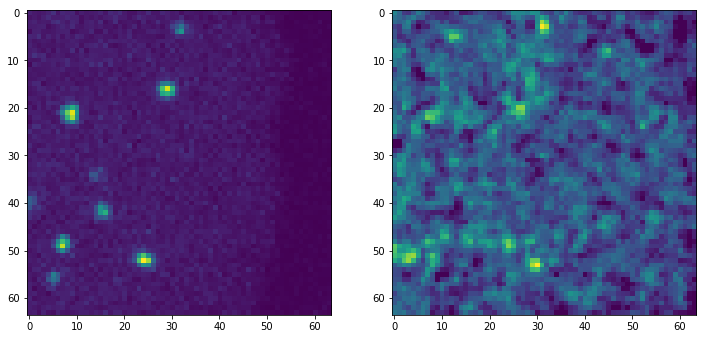

In [115]:
idx = np.random.choice(range(img.shape[0]))
fig, ax = plt.subplots(1,2,figsize=[12,6])
ax[0].imshow(img[idx,0,:,:].data.cpu())
ax[1].imshow(test_decoder_model(img[idx,:,:,:].cuda()).view(64,64).data.cpu())
plt.show()